My Info: Pelipper CP 1490
Opponent Info: CP 1499 Graveler


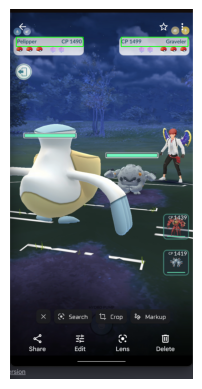

In [103]:
import cv2
import numpy as np
from Quartz import CGWindowListCopyWindowInfo, kCGWindowListOptionOnScreenOnly, kCGWindowListExcludeDesktopElements, kCGNullWindowID
from AppKit import NSScreen
from mss import mss
import matplotlib.pyplot as plt
import pytesseract

# Find the scrcpy window
def find_scrcpy_window(owner_name):
    window_info_list = CGWindowListCopyWindowInfo(kCGWindowListOptionOnScreenOnly | kCGWindowListExcludeDesktopElements, kCGNullWindowID)
    for window_info in window_info_list:
        window_owner_name = window_info.get('kCGWindowName', '')
        if owner_name in window_owner_name:
            return window_info
    return None

# Capture the scrcpy window
def capture_scrcpy_window(window, phone_dim):
    x = window['kCGWindowBounds']['X']
    y = NSScreen.mainScreen().frame().size.height - window['kCGWindowBounds']['Y'] - window['kCGWindowBounds']['Height'] - phone_dim[0]
    width = window['kCGWindowBounds']['Width']
    height = window['kCGWindowBounds']['Height'] - phone_dim[1]

    with mss() as sct:
        monitor = {'left': int(x), 'top': int(y), 'width': int(width), 'height': int(height)}
        screenshot = sct.grab(monitor)
        screenshot_np = np.array(screenshot)

    return screenshot_np

phones = ['Pixel 3 XL', 'Pixel 7 Pro']
phone_dim = [[0, 40], [90, 30]]
use_phone = 0
phone_dim = phone_dim[use_phone]
scrcpy_window = find_scrcpy_window(phones[use_phone])

if scrcpy_window:
    screen = capture_scrcpy_window(scrcpy_window, phone_dim)

    my_roi = (23, 105, 250, 35)
    opp_roi = (415, 105, 250, 35)

    my_roi_img = screen[my_roi[1]:my_roi[1] + my_roi[3], my_roi[0]:my_roi[0] + my_roi[2]]
    opp_roi_img = screen[opp_roi[1]:opp_roi[1] + opp_roi[3], opp_roi[0]:opp_roi[0] + opp_roi[2]]

    gray_my_roi = cv2.cvtColor(my_roi_img, cv2.COLOR_BGR2GRAY)
    gray_opp_roi = cv2.cvtColor(opp_roi_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale images
    blur_my_roi = cv2.GaussianBlur(gray_my_roi, (5, 5), 0)
    blur_opp_roi = cv2.GaussianBlur(gray_opp_roi, (5, 5), 0)

    # Apply binary thresholding
    _, thresh_my_roi = cv2.threshold(blur_my_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, thresh_opp_roi = cv2.threshold(blur_opp_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise
    kernel = np.ones((2, 2), np.uint8)
    thresh_my_roi = cv2.morphologyEx(thresh_my_roi, cv2.MORPH_OPEN, kernel)
    thresh_opp_roi = cv2.morphologyEx(thresh_opp_roi, cv2.MORPH_OPEN, kernel)

    # Use pytesseract to extract text from the processed images
    my_info = pytesseract.image_to_string(thresh_my_roi, config='--psm 6').strip()
    opp_info = pytesseract.image_to_string(thresh_opp_roi, config='--psm 6').strip()

    # Display the extracted Pokémon name and CP value
    print("My Info:", my_info)
    print("Opponent Info:", opp_info)

    # Draw rectangles around the ROIs on the screen
    roi_color = (0, 255, 0)  # Color for the rectangle (green in this case)
    screen_with_rois = cv2.rectangle(screen.copy(), (my_roi[0], my_roi[1]), (my_roi[0] + my_roi[2], my_roi[1] + my_roi[3]), roi_color, 2)
    screen_with_rois = cv2.rectangle(screen_with_rois, (opp_roi[0], opp_roi[1]), (opp_roi[0] + opp_roi[2], opp_roi[1] + opp_roi[3]), roi_color, 2)

    plt.imshow(cv2.cvtColor(screen_with_rois, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.show()
else:
    print('scrcpy window not found.')



In [ ]:
# import Quartz
# for window in Quartz.CGWindowListCopyWindowInfo(Quartz.kCGWindowListOptionOnScreenOnly | Quartz.kCGWindowListExcludeDesktopElements, Quartz.kCGNullWindowID):
#     print("%s - %s" % (window['kCGWindowOwnerName'], window.get('kCGWindowName', u'Unknown').encode('ascii','ignore')))